# Precesion de la barra

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]



i=0
snapshot=range(496,250,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    fo =open('/home/ornela/python/barra/precesion.dat','a')
    #print isnap
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    #IDs = snap['subhalo_000/Str/Ids'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

    #------------------masa total en r200 (Mvir)--------------------------         
    #corte1,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
    
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50[-1]
        #print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        #print 'segundo', isnap
        raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        #print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        #print 'cuarto', isnap
    

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,raux)
    
    f1x,f2x,f3x,f1y,f2y,f3y,f1z,f2z,f3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn1 = e1z
    yn1 = e2z
    zn1 = e3z
    
    xn2 = f1z
    yn2 = f2z
    zn2 = f3z
    
    mod1 = np.sqrt(xn1**2+yn1**2+zn1**2)
    mod2 = np.sqrt(xn2**2+yn2**2+zn2**2)
    
    escalar = xn1*xn2 + yn1*yn2 + zn1*zn2
    signo = np.sign(escalar)
    tita = signo*arccos(abs(escalar)/(mod1*mod2))
    
    tita = tita*180./pi
    
    fo.write(str('%03d'%isnap) +'\t'+
             str('%.6f'% t) +'\t'+
             str('%12.6f'% tita) +'\n')
    fo.close()

       
    i += 1

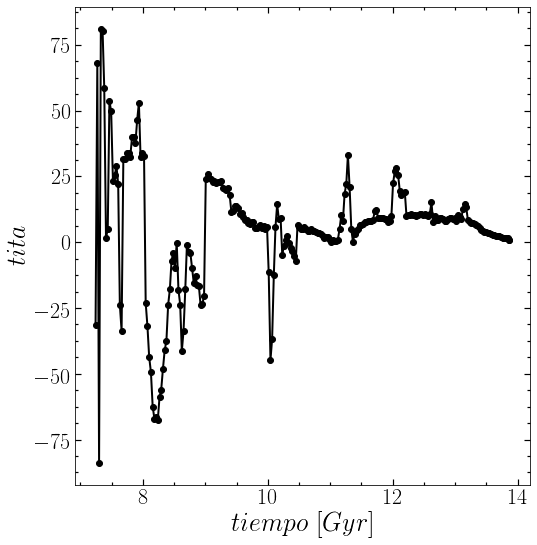

In [5]:
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm2=np.loadtxt('/home/ornela/python/barra/precesion.dat')

t =cm2[:,1]
tita =cm2[:,2]

# time =[]
# A2=[]
# aux=range(0,len(t),1)
# for j in aux:
#     time.append(t[j])
#     A2.append(A2max[j])

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(t,tita,'o-', lw=2, color='k')
#ax3.set_xlim(2,14)
#ax3.set_ylim(0.04,0.45)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
plt.xlabel(r'$tiempo$ $[Gyr]$', fontsize=26)
plt.ylabel(r'$tita$',fontsize=26)

plt.show()